In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Below is code with a link to a happy or sad dataset which contains 80 images, 40 happy and 40 sad. 
Create a convolutional neural network that trains to 100% accuracy on these images,  which cancels training upon hitting training accuracy of >.999

Hint -- it will work best with 3 convolutional layers.

## Download files and Create callback class 

In [2]:
import tensorflow as tf
import os
import zipfile


DESIRED_ACCURACY = 0.999

!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip" \
    -O "/tmp/happy-or-sad.zip"

zip_ref = zipfile.ZipFile("/tmp/happy-or-sad.zip", 'r')
zip_ref.extractall("/tmp/h-or-s")
zip_ref.close()

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > DESIRED_ACCURACY):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

--2020-06-30 08:43:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 209.85.145.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/tmp/happy-or-sad.zip’

/tmp/happy-or-sad.z 100%[===================>]   2.55M  --.-KB/s    in 0.02s   

2020-06-30 08:43:26 (150 MB/s) - ‘/tmp/happy-or-sad.zip’ saved [2670333/2670333]



## Mount the files and display the images

In [3]:
# Directory with our training happy pictures
train_happy_dir = os.path.join('/tmp/h-or-s/happy')

# Directory with our training sad pictures
train_sad_dir = os.path.join('/tmp/h-or-s/sad')

train_happy_names = os.listdir(train_happy_dir)
train_sad_names = os.listdir(train_sad_dir)
print('total training happy images:', len(train_happy_names))
print('total training sad images:', len(train_sad_names))

total training happy images: 40
total training sad images: 40


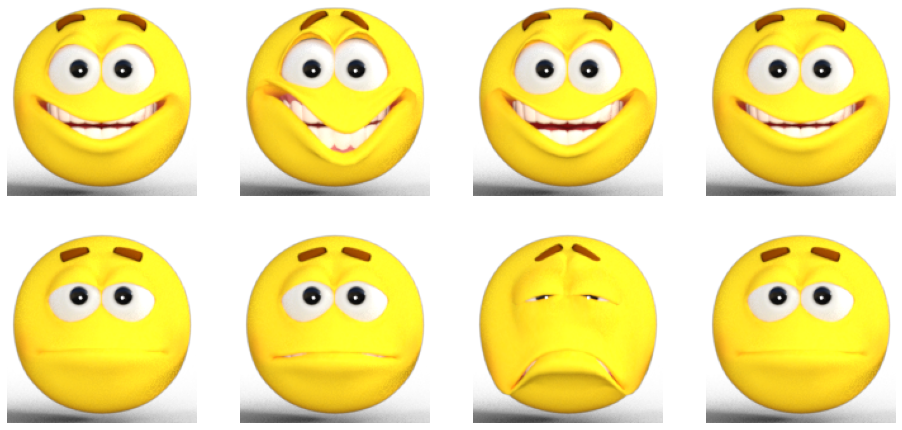

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_happy_pix = [os.path.join(train_happy_dir, fname) 
                for fname in train_happy_names[-4:]]
next_sad_pix = [os.path.join(train_sad_dir, fname) 
                for fname in train_sad_names[-4:]]

for i, img_path in enumerate(next_happy_pix+next_sad_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)

    # Don't show axes (or gridlines)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Build the model and optimizer

In [12]:
# This Code Block should Define and Compile the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

## Define the ImageDataGenerator and start training

In [11]:
# This code block should create an instance of an ImageDataGenerator called train_datagen 
# And a train_generator by calling train_datagen.flow_from_directory

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    '/tmp/h-or-s/',
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary'
)

# Expected output: 'Found 80 images belonging to 2 classes'

Found 80 images belonging to 2 classes.


In [13]:
# This code block should call model.fit and train for a number of epochs. 

history = model.fit(
    train_generator,
    steps_per_epoch=8,
    epochs=15,
    verbose=1,
    callbacks=[callbacks]
)

# Expected output: "Reached 99.9% accuracy so cancelling training!""

Epoch 1/15
8/8 [==============================] - 0s 22ms/step - loss: 1.3567 - accuracy: 0.6625
Epoch 2/15
8/8 [==============================] - 0s 22ms/step - loss: 0.4015 - accuracy: 0.8750
Epoch 3/15
8/8 [==============================] - 0s 22ms/step - loss: 0.2908 - accuracy: 0.8625
Epoch 4/15
8/8 [==============================] - 0s 23ms/step - loss: 0.1856 - accuracy: 0.9250
Epoch 5/15
8/8 [==============================] - 0s 24ms/step - loss: 0.3209 - accuracy: 0.8875
Epoch 6/15
8/8 [==============================] - 0s 23ms/step - loss: 0.1079 - accuracy: 0.9750
Epoch 7/15
8/8 [==============================] - 0s 22ms/step - loss: 0.2178 - accuracy: 0.9125
Epoch 8/15
8/8 [==============================] - 0s 22ms/step - loss: 0.0960 - accuracy: 0.9625
Epoch 9/15
8/8 [==============================] - 0s 24ms/step - loss: 0.1376 - accuracy: 0.9250
Epoch 10/15
6/8 [=====================>........] - ETA: 0s - loss: 0.0367 - accuracy: 1.0000
Reached 99.9% accuracy so cancelli